# IMU Motion Reconstruction


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------------------------
# IMU data processing helper functions for motion analysis
# -----------------------------------------------------------

def load_imu_file(path):
    df = pd.read_csv(path, comment='/', sep=',')
    t0 = df['SampleTimeFine'].iloc[0]
    df['t'] = (df['SampleTimeFine'] - t0) * 1e-4
    return df

def estimate_sampling_time(df):
    dt_ticks = df['SampleTimeFine'].diff().dropna().mode()[0]
    dt = dt_ticks * 1e-4
    return dt

def simple_motion_phase(df, acc_col='Acc_X', gyr_col='Gyr_Z',
                        acc_thresh=0.15, gyr_thresh=0.02):
    ax = df[acc_col].values
    gz = df[gyr_col].values

    phases = []
    for a, g in zip(ax, gz):
        if abs(a) < acc_thresh and abs(g) < gyr_thresh:
            phases.append('stopped')
        elif abs(g) > gyr_thresh:
            phases.append('turning')
        elif abs(a) > acc_thresh:
            phases.append('accel/brake')
        else:
            phases.append('cruise')
    return np.array(phases)

def integrate_gyro_to_yaw(df, gyr_col='Gyr_Z'):
    dt = estimate_sampling_time(df)
    gz = df[gyr_col].values
    n_bias = max(1, int(1.0 / dt))
    bias = np.mean(gz[:n_bias])
    gz_corr = gz - bias
    yaw = np.cumsum(gz_corr) * dt
    return yaw

def integrate_acc_to_velocity(df, acc_col='Acc_X', phases=None):
    dt = estimate_sampling_time(df)
    a = df[acc_col].values
    n_bias = max(1, int(1.0 / dt))
    bias = np.mean(a[:n_bias])
    a_corr = a - bias

    v = np.zeros_like(a_corr)
    for i in range(1, len(a_corr)):
        v[i] = v[i-1] + a_corr[i] * dt
        if phases is not None and phases[i] == 'stopped':
            v[i] = 0.0
    return v

def integrate_to_xy(v, yaw, df):
    dt = estimate_sampling_time(df)
    x = np.zeros_like(v)
    y = np.zeros_like(v)
    for i in range(1, len(v)):
        x[i] = x[i-1] + v[i] * np.cos(yaw[i]) * dt
        y[i] = y[i-1] + v[i] * np.sin(yaw[i]) * dt
    return x, y


Each subsequent cell renders a single plot. First, the short trajectory plots (file 004) then the long trajectory plots (006)

In [3]:
# File004: load and compute derived signals
df1 = load_imu_file("MT_0080001528_004-000.txt")
phases1 = simple_motion_phase(df1)
yaw1 = integrate_gyro_to_yaw(df1)
v1 = integrate_acc_to_velocity(df1, phases=phases1)
x1, y1 = integrate_to_xy(v1, yaw1, df1)

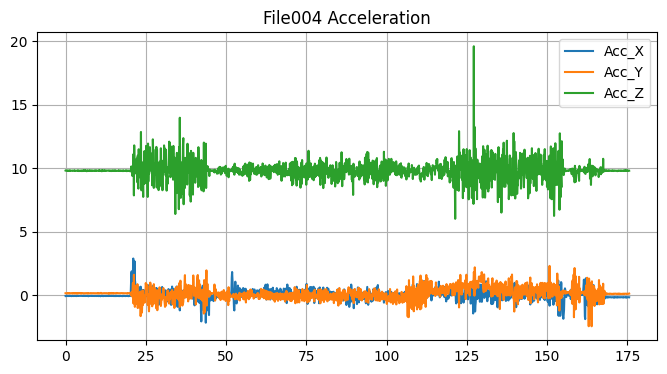

In [4]:
# File004: Acceleration
t = df1['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df1['Acc_X'], label='Acc_X')
plt.plot(t, df1['Acc_Y'], label='Acc_Y')
plt.plot(t, df1['Acc_Z'], label='Acc_Z')
plt.legend(); plt.grid(); plt.title("File004 Acceleration")
plt.show()

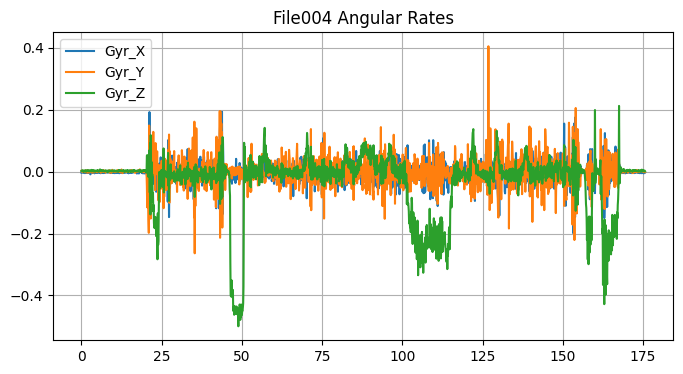

In [5]:
# File004: Angular Rates
t = df1['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df1['Gyr_X'], label='Gyr_X')
plt.plot(t, df1['Gyr_Y'], label='Gyr_Y')
plt.plot(t, df1['Gyr_Z'], label='Gyr_Z')
plt.legend(); plt.grid(); plt.title("File004 Angular Rates")
plt.show()

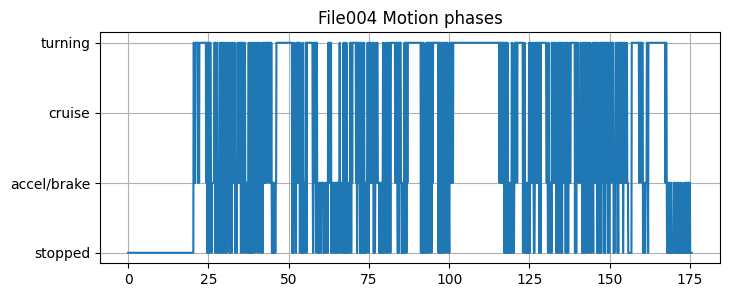

In [6]:
# File004: Motion phases
t = df1['t'].values
phase_map = {'stopped':0, 'accel/brake':1, 'cruise':2, 'turning':3}
phase_vals = np.array([phase_map[p] for p in phases1])
plt.figure(figsize=(8,3))
plt.plot(t, phase_vals)
plt.yticks(list(phase_map.values()), list(phase_map.keys()))
plt.grid(); plt.title("File004 Motion phases")
plt.show()

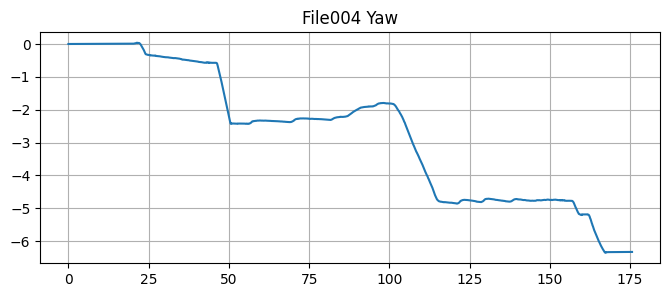

In [7]:
# File004: Yaw
t = df1['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, yaw1)
plt.grid(); plt.title("File004 Yaw")
plt.show()

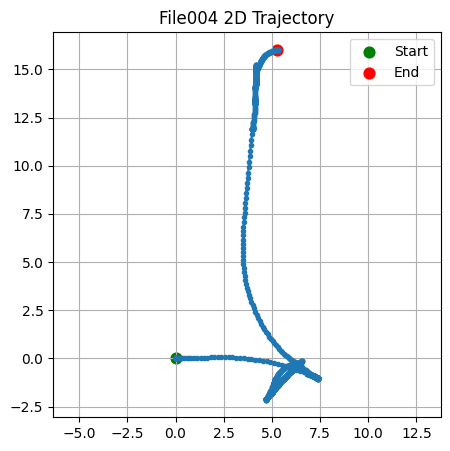

In [8]:
# File004: 2D Trajectory
plt.figure(figsize=(5,5))
plt.plot(x1, y1, marker='.')
# Start/end markers
plt.scatter([x1[0]], [y1[0]], color='green', s=60, label='Start')
plt.scatter([x1[-1]], [y1[-1]], color='red', s=60, label='End')
plt.axis('equal'); plt.grid()
plt.title("File004 2D Trajectory")
plt.legend()
plt.show()

In [9]:
# File006: load and compute derived signals
df2 = load_imu_file("MT_0080001528_006-000.txt")
phases2 = simple_motion_phase(df2)
yaw2 = integrate_gyro_to_yaw(df2)
v2 = integrate_acc_to_velocity(df2, phases=phases2)
x2, y2 = integrate_to_xy(v2, yaw2, df2)

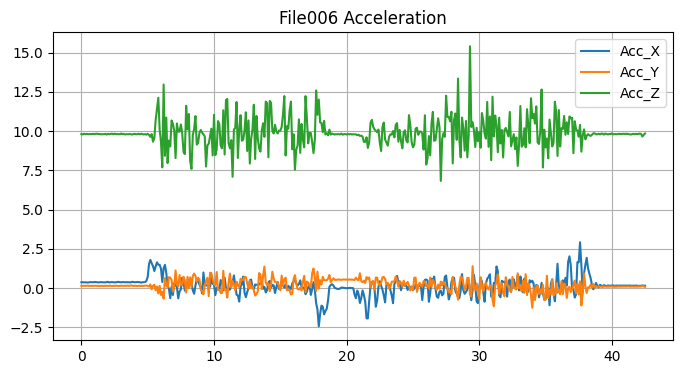

In [10]:
# File006: Acceleration
t = df2['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df2['Acc_X'], label='Acc_X')
plt.plot(t, df2['Acc_Y'], label='Acc_Y')
plt.plot(t, df2['Acc_Z'], label='Acc_Z')
plt.legend(); plt.grid(); plt.title("File006 Acceleration")
plt.show()

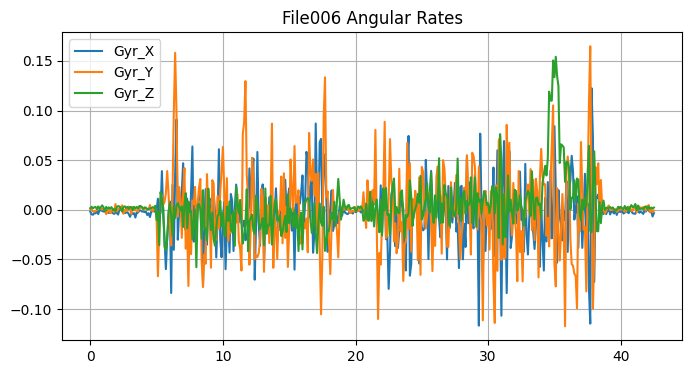

In [11]:
# File006: Angular Rates
t = df2['t'].values
plt.figure(figsize=(8,4))
plt.plot(t, df2['Gyr_X'], label='Gyr_X')
plt.plot(t, df2['Gyr_Y'], label='Gyr_Y')
plt.plot(t, df2['Gyr_Z'], label='Gyr_Z')
plt.legend(); plt.grid(); plt.title("File006 Angular Rates")
plt.show()

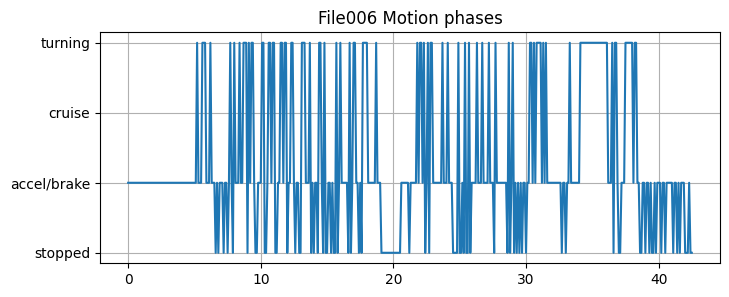

In [12]:
# File006: Motion phases
t = df2['t'].values
phase_map = {'stopped':0, 'accel/brake':1, 'cruise':2, 'turning':3}
phase_vals = np.array([phase_map[p] for p in phases2])
plt.figure(figsize=(8,3))
plt.plot(t, phase_vals)
plt.yticks(list(phase_map.values()), list(phase_map.keys()))
plt.grid(); plt.title("File006 Motion phases")
plt.show()

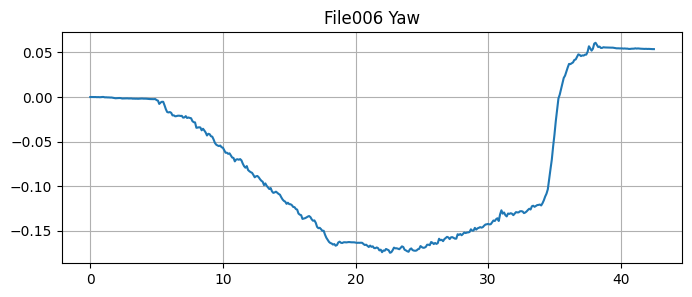

In [13]:
# File006: Yaw
t = df2['t'].values
plt.figure(figsize=(8,3))
plt.plot(t, yaw2)
plt.grid(); plt.title("File006 Yaw")
plt.show()

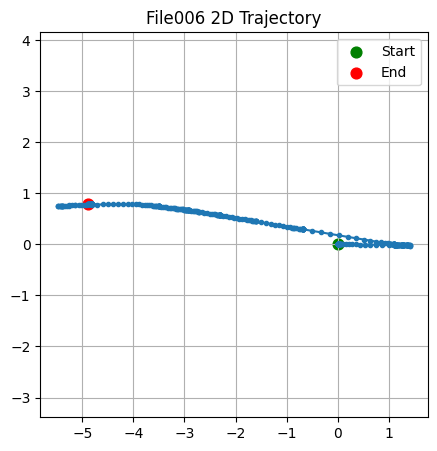

In [14]:
# File006: 2D Trajectory
plt.figure(figsize=(5,5))
plt.plot(x2, y2, marker='.')
# Start/end markers
plt.scatter([x2[0]], [y2[0]], color='green', s=60, label='Start')
plt.scatter([x2[-1]], [y2[-1]], color='red', s=60, label='End')
plt.axis('equal'); plt.grid()
plt.title("File006 2D Trajectory")
plt.legend()
plt.show()

## Interpretation ##

The first file is essentially an out-and-back manoeuvre on a straight line:

From the entrance, the robot accelerated straight into the corridor, went forward a few meters, then braked, reversed back past the starting point, and came to rest slightly behind and to one side of its original position, almost facing the same direction.

The second file: 

Starting at the CLC entrance, the robot remained stationary for a while, then drove straight down the main corridor. Near the far end it performed several small forward–backward corrections and rotations (probably at an intersection or open area). After that, it turned and drove down a perpendicular corridor, ending roughly 15–17 meters away from the entrance, in a side corridor, where it finally stopped.

## How the 2D trajectory is computed

1) Data loading and timebase:
- `load_imu_file(path)` reads the CSV and creates a time vector `t` from `SampleTimeFine` (ticks = 100 µs).

2) Sampling period:
- `estimate_sampling_time(df)` computes the dominant time step `dt` from `SampleTimeFine` differences.

3) Motion phases:
- `simple_motion_phase(df, acc_col='Acc_X', gyr_col='Gyr_Z')` labels each sample as `stopped`, `turning`, `accel/brake`, or `cruise` using thresholds.

4) Yaw estimation (heading):
- `integrate_gyro_to_yaw(df, gyr_col='Gyr_Z')` subtracts an initial gyro bias (≈1 s mean) and integrates yaw-rate to get yaw over time.

5) Forward velocity:
- `integrate_acc_to_velocity(df, acc_col='Acc_X', phases)` subtracts an initial accelerometer bias and integrates acceleration to velocity; when phase is `stopped`, velocity is clamped to 0 to limit drift.

6) 2D dead-reckoning:
- `integrate_to_xy(v, yaw, df)` integrates the velocity components projected by yaw:
  - `x[i] = x[i-1] + v[i] * cos(yaw[i]) * dt`
  - `y[i] = y[i-1] + v[i] * sin(yaw[i]) * dt`
  This produces the planar trajectory `(x, y)`.

7) Plotting and markers:
- The trajectory cells plot `(x, y)` and add green and red markers for the start `(x[0], y[0])` and end `(x[-1], y[-1])`, respectively.

Limitations: This is pure dead-reckoning without magnetometer fusion for heading, so long runs accumulate drift. Phase-based zeroing helps but does not eliminate drift.